In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss

# Autocorrelate Function

In [47]:
# def autocorrelate(syg, tau=0):
#     N = len(syg)

#     syg_2 = np.zeros(3*N-2, dtype = 'float')
#     syg_2[N-1:2*N-1] = np.copy(syg)

#     syg_1 = np.zeros(3*N-2, dtype= 'float')
#     syg_1[N+tau:tau+2*N] = np.copy(syg)
    
#     return np.dot(syg_1, syg_2)

def auto_corr_for_tau(syg, low=-10, high=10, normed=True):
    tau = np.arange(low, high)

    f_corr = np.zeros(len(tau))
    norm = autocorrelate(syg)

    for index, t in enumerate(tau):
        f_corr[index] = covar(syg, syg, t)

    if normed:
        f_corr /= norm

    return tau, f_corr

def covar(syg_1,syg_2, tau=0):
    if syg_1.shape != syg_2.shape:
        raise ValueError("Can't compare size %d with %d"%(syg_1.shape, syg_2.shape))
    
    N = len(syg_1)

    _syg_2 = np.zeros(3*N-2, dtype = 'float')
    _syg_2[N-1:2*N-1] = np.copy(syg_2) - np.std(syg_2)

    _syg_1 = np.zeros(3*N-2, dtype= 'float')
    _syg_1[N+tau:tau+2*N] = np.copy(syg_1) - np.std(syg_1)
    
    
    return np.dot(_syg_1, _syg_2)

def corr(x, y, K):
    x = np.array(x)
    y = np.array(y)
    
    N = len(x)
    K = np.arange(K)

    corr = np.zeros(N)
    for j, k in enumerate(K):
        co = 0
        x_mean = np.mean(x)
        y_mean = np.mean(y)
        for i in range(N - k):
            co += (x[i + k] - x_mean) * (y[i] - y_mean)
        corr[j] = co
    
#     print(co)
    corr /= N-1
    
    corr = np.concatenate(corr[::-1], corr)
    
#     print(co)
#     co /= np.std(x) * np.std(y)
    
    return co

def auto_covar(syg_1, syg_2, normed=True):
    if syg_1.shape != syg_2.shape:
        raise ValueError("Can't compare size %d with %d"%(syg_1.shape, syg_2.shape))
    
    low = -len(syg_1)
    high = len(syg_1) - 1
     
    tau = np.arange(low, high)

#     syg_1 -= np.mean(syg_1)
#     syg_2 -= np.mean(syg_2)
    
    f_corr = np.zeros(len(tau))
    norm = np.std(syg_1) * np.std(syg_2)
    
    if np.array_equal(syg_1, syg_2):
        norm2 = covar(syg_1,syg_2)
        print(norm, norm2, norm2/norm, norm == norm2)

    for index, t in enumerate(tau):
        f_corr[index] = covar(syg_1, syg_2, t)

    if normed:
        f_corr /= norm

    return tau, f_corr


In [27]:
t = np.arange(0, 2, 1/32)
x = np.sin(2 * np.pi * 1 * t)

NameError: name 'autocorrelate' is not defined

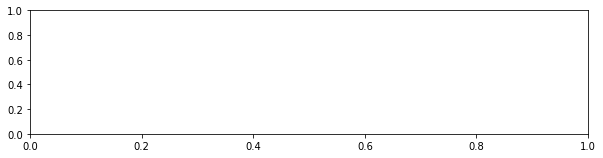

In [28]:
plt.figure(figsize=((10,5)))

plt.subplot(2,1,1)
plt.plot(*auto_corr_for_tau(x, -len(x), len(x)-1))

plt.subplot(2,1,2)
plt.plot(np.correlate(x, x, 'full'))
plt.show()

plt.figure(figsize=((10,5)))
plt.plot(*auto_corr_for_tau(x, -len(x), len(x)-1, normed=False))
plt.plot(np.correlate(x, x, 'full'))
plt.show()

In [49]:
for i in range(2, 3):
    print(corr(np.array([1,2,3]), np.array([-1, -2, -3]), i))

0.5


# Read Signal

In [6]:
from obci_readmanager.signal_processing.read_manager import ReadManager
from pprint import pprint
def read_signals(filename, channels):
    TMSI_OFFSET = 0.0715

    # Initialize the ReadManager
    mgr = ReadManager(filename + ".xml", filename + ".raw", filename + ".tag")
    
    signals = mgr.get_channels_samples(channels) * TMSI_OFFSET
    return signals

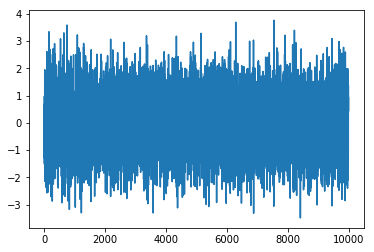

NameError: name 'autocorrelate' is not defined

In [7]:
np.random.seed(10000)
x = np.random.normal(size=10000).astype('float')
plt.plot(x)
plt.show()

plt.plot(auto_corr_for_tau(x, -len(x), len(x)-1, normed=False)[1], color='red')
# plt.plot(np.correlate(x, x, 'full'))
plt.show()

In [8]:
o1 = read_signals('../../../data/cw1_otwarte', ['O1'])

2018-10-11 16:12:49,130 - tags_file_reader - ERROR - Couldn`t open tags file.
2018-10-11 16:12:49,131 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


In [9]:
o2 = read_signals('../../../data/cw1_zamkniete', ['O1'])

2018-10-11 16:13:11,003 - tags_file_reader - ERROR - Couldn`t open tags file.
2018-10-11 16:13:11,004 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


In [10]:
def filter_signal(signal):
    b_highpass, a_highpass = ss.butter(2, 1 / 1024/2, 'highpass')
    b_lowpass, a_lowpass = ss.butter(4, 40 / 1024/2, 'low')
    b_notch, a_notch = ss.iirnotch(50 / 1024/2, 30)
    filt = np.copy(signal)
    filt = ss.filtfilt(b_notch, a_notch, filt)
    filt = ss.filtfilt(b_highpass, a_highpass, filt)
    filt = ss.filtfilt(b_lowpass, a_lowpass, filt)
    return filt

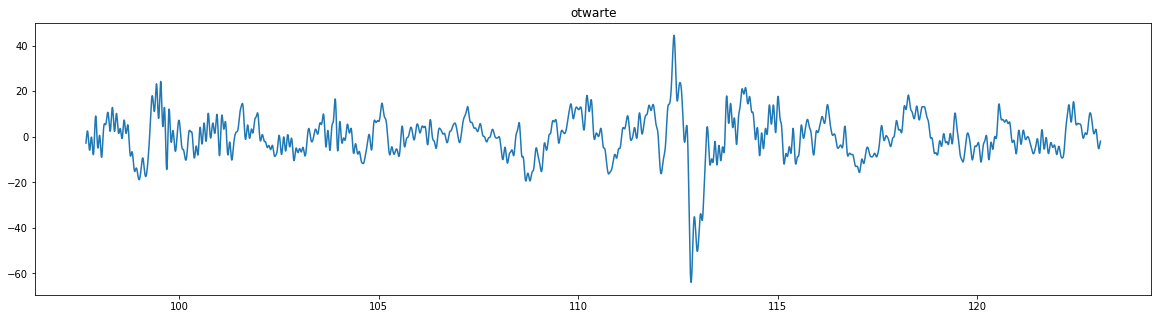

In [11]:
t = np.arange(0, len(o1)) / 1024
filt_o1 = filter_signal(o1)[100000:-500000]

plt.figure(figsize=(20, 5))
plt.plot(t[100000:-500000], filt_o1)
plt.title('otwarte')
plt.show()

In [12]:
plt.figure(figsize=(20,5))
t, corr = auto_corr_for_tau(filt_o1, -len(filt_o1), len(filt_o1)-1, normed=True)
plt.plot(t/1024, corr, color='red')
plt.xlim(0,1)
plt.show()

NameError: name 'autocorrelate' is not defined

In [ ]:
t = np.arange(0, len(o2)) / 1024

start = 3 * 60 * 1024

filt_o2 = filter_signal(o2)[start:start + 1024*10]

plt.figure(figsize=(20, 5))
plt.plot(t[start:start + 1024*10], filt_o2)
plt.title('zamkniete')
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
t, corr = auto_corr_for_tau(filt_o2, -len(filt_o2), len(filt_o2)-1, normed=True)
plt.plot(t/1024, corr, color='red')
plt.xlim(0,1)
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(np.fft.rfftfreq(len(corr), 1/1024)[:250], abs(np.fft.rfft(corr)[:250]))
plt.show()

In [ ]:
f, t, s = ss.spectrogram(corr, 1024)
plt.pcolormesh(t, f, s)
plt.imshow(s)
plt.ylabel('Hz')
plt.xlabel('s')
plt.ylim(0,20)
plt.show()

In [ ]:
F, P = ss.welch(filt_o2, 1024, window='hanning')

In [ ]:
plt.plot(F,P)
plt.xlim(0,40)
plt.show()

# Zadanie 3

In [13]:
channels = ['Fp1', 'Fp2', 'P3', 'Pz', 'P4', 'O1', 'O2']
signals_closed = read_signals('../../../data/cw1_zamkniete', channels)

2018-10-11 16:13:44,758 - tags_file_reader - ERROR - Couldn`t open tags file.
2018-10-11 16:13:44,759 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


In [14]:
Fs = 1024
nyq = Fs/2
t = np.arange(0, signals_closed.shape[1]) / Fs
start = int(1.5 * 60 * Fs)
end = int(start + 1 * Fs)

In [15]:
filtered_closed = filter_signal(signals_closed)

0 0 1
28.203226435082705 44035.525945739384 1561.3648334561638 False
0 1 2
0 2 3
0 3 4
0 4 5
0 5 6
0 6 7
1 0 8
1 1 9
43.98332736055476 138376.77862364252 3146.1189256850525 False
1 2 10
1 3 11
1 4 12
1 5 13
1 6 14
2 0 15
2 1 16
2 2 17
61.524467250246765 114799.21387377122 1865.9115471383586 False
2 3 18
2 4 19
2 5 20
2 6 21
3 0 22
3 1 23
3 2 24
3 3 25
56.958784555034185 98097.30995870527 1722.2507594754345 False
3 4 26
3 5 27
3 6 28
4 0 29
4 1 30
4 2 31
4 3 32
4 4 33
59.04345638929289 129147.92389958649 2187.336782048663 False
4 5 34
4 6 35
5 0 36
5 1 37
5 2 38
5 3 39
5 4 40
5 5 41
51.61084299765151 88188.1400175294 1708.7134194173557 False
5 6 42
6 0 43
6 1 44
6 2 45
6 3 46
6 4 47
6 5 48
6 6 49
38.83529794759943 87714.53014252338 2258.6289993417026 False


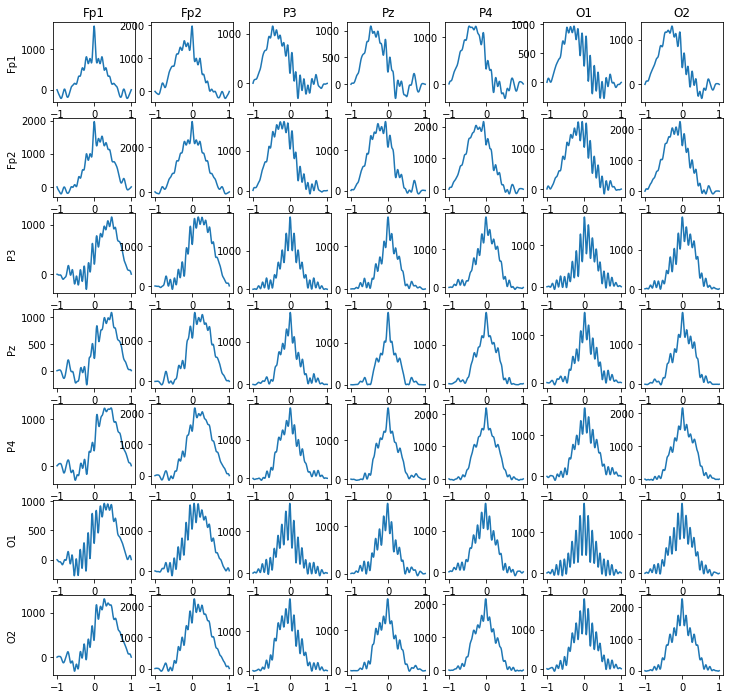

In [25]:
plt.figure(figsize=(12,12))

for i, x in enumerate(filtered_closed):
    for j, y in enumerate(filtered_closed):
        print(i, j, (j+1) + (i*filtered_closed.shape[0]))
        
        
        plt.subplot(filtered_closed.shape[0], filtered_closed.shape[0], (j+1) + (i*filtered_closed.shape[0]))
        
        if j == 0:
            plt.ylabel(channels[i])
        if not i:
            plt.title(channels[j])
        t, cov = auto_covar(x[start: end], y[start: end], normed=True)
        t = t/Fs
        plt.plot(t, cov)
#         plt.ylim(-1,1)
        
plt.show()

# 

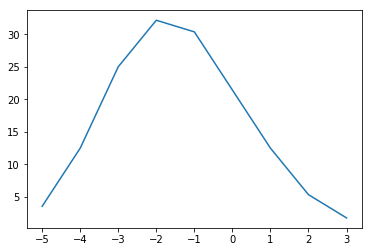

In [17]:
plt.plot(*auto_covar(np.array([1,2,3,2,1]),np.array([2,3,2,1,1])))